In [1]:
%env CUDA_VISIBLE_DEVICES=0,1,2,3

env: CUDA_VISIBLE_DEVICES=0,1,2,3


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as onp
import h5py

import jax
from jax import vmap
import jax.numpy as np
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from scipy.stats import norm

from time import time

import os, sys
sys.path.append(os.path.split(os.getcwd())[0])
import scripts.transform_data as transform

In [3]:
plt.rcParams['font.size'] = 12

In [4]:
N_GPU = sum([i.isdigit() for i in os.environ.get('CUDA_VISIBLE_DEVICES')])
if N_GPU>0:
    numpyro.set_platform('gpu')   
    numpyro.set_host_device_count(N_GPU)
    N_chains = N_GPU
else:
    N_chains = 1

print(jax.devices())    

[GpuDevice(id=0), GpuDevice(id=1), GpuDevice(id=2), GpuDevice(id=3)]


# Process Data

In [5]:
def initial_processing(df):
    
    for c in ['China', 'Iran', 'Italy', 'Diamond Princess']:
        df = df[df['Country/Region']!=c]
    
    df['Country/Region'].iloc[~df['Province/State'].isnull().values] += ' / '+df['Province/State']
    df = df.drop(columns=['Province/State', 'Lat', 'Long'])
    df.set_index(keys='Country/Region', inplace=True)
    
    return df

In [6]:
# Read in file
d_df = pd.read_csv('../data/IRD/deaths.csv')
t_df = pd.read_csv('../data/weather/temperature.csv')
h_df = pd.read_csv('../data/weather/humidity.csv')
# Drop China, Iran and Italy
d_df = initial_processing(d_df)
t_df = initial_processing(t_df)
h_df = initial_processing(h_df)
# Drop low deaths
d_df = d_df[(d_df.max(axis=1)>10)]
t_df = t_df.T[d_df.index.values].T
h_df = h_df.T[d_df.index.values].T

In [7]:
deaths = {}
temps = {}
hums = {}
max_days = 28
start_days = np.argmax((d_df.values>4),axis=1)
for i, country in enumerate(d_df.index):
    deaths[country] = d_df.T[country].values[start_days[i]:start_days[i]+max_days]
    temps[country] = t_df.T[country].values[start_days[i]:start_days[i]+max_days]
    hums[country] = h_df.T[country].values[start_days[i]:start_days[i]+max_days]

In [8]:
pops = transform.population()

Number of unmatched regions : 46
Population data saved @ /data/COVID-19/covid19/data/population/populations.csv


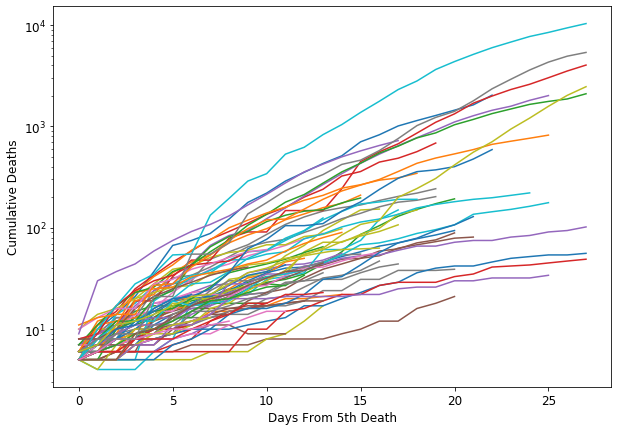

In [9]:
plt.figure(figsize=(10,7))
for c in deaths.keys():
    try:
        plt.semilogy(deaths[c], label=c);
    except:
        pass
plt.ylabel('Cumulative Deaths')
plt.xlabel('Days From 5th Death')
plt.savefig('../plots/Deaths_Growth.png')
# plt.legend(ncol=3)

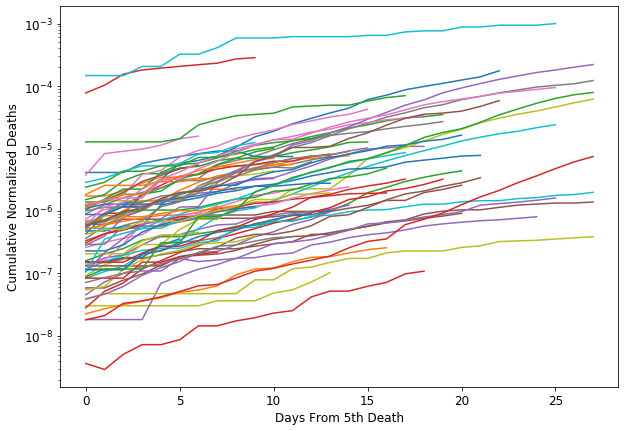

In [10]:
plt.figure(figsize=(10,7))
for c in deaths.keys():
    try:
        plt.semilogy(deaths[c]/pops[c].values, label=c);
    except:
        pass
plt.ylabel('Cumulative Normalized Deaths')
plt.xlabel('Days From 5th Death')
plt.savefig('Deaths_Growth_Normed.png')
# plt.legend(ncol=3)

In [11]:
np.sum([len(deaths[c]) for c in deaths.keys()])

DeviceArray(1294, dtype=int32)

# Bayesian Model

For each country $i$ a forward model as follows is fitted

$$ D_i(t) = D^0_i(R_i + \alpha_i T + \beta_i H)^t$$

Each parameter ($D^0_i, R_i, \alpha_i, \beta_i$) has a parent distribution.

$D^0_i$ is the number of deaths at day 0.

$R_i$ is the base growth rate in cumulative deaths per day.

$\alpha_i$ is the temperature (measured in $^\circ$C) coefficient gving the temperature dependence of the overall growth rate.

$\beta_i$ is the humidity (relative humidity measured from 0 to 1) coefficient gving the temperature dependence of the overall growth rate.


In [12]:
def model():
    
    N = len(deaths)
    
    ############
    # Starting Deaths
    # Group mean
    a_grp = numpyro.sample('a_grp', dist.Normal(1, 0.5))
    # Group variance
    a_grp_sigma = numpyro.sample('a_grp_sigma', dist.HalfNormal(0.5))
    # Individual intercepts
    a_ind = numpyro.sample('a_ind', dist.Normal(a_grp*np.ones(N), a_grp_sigma*np.ones(N)))
    
    ########
    # Base Growth Rate
    # Group mean
    r_grp = numpyro.sample('r_grp', dist.Normal(1.33, 0.5))
    # Group variance
    r_grp_sigma = numpyro.sample('r_grp_sigma', dist.HalfNormal(0.5))
    # Individual slopes
    r_ind = numpyro.sample('r_ind', dist.Normal(r_grp*np.ones(N), r_grp_sigma*np.ones(N)))
    
    
    ########
    # Temperature Coefficient
    # Group mean
    t_grp = numpyro.sample('t_grp', dist.Normal(0.0, 0.1))
    # Group variance
    t_grp_sigma = numpyro.sample('t_grp_sigma', dist.HalfNormal(0.1))
    # Individual slopes
    t_ind = numpyro.sample('t_ind', dist.Normal(t_grp*np.ones(N), t_grp_sigma*np.ones(N)))
    
    ########
    # Humidity Coefficient
    # Group mean
    h_grp = numpyro.sample('h_grp', dist.Normal(0.0, 0.1))
    # Group variance
    h_grp_sigma = numpyro.sample('h_grp_sigma', dist.HalfNormal(0.1))
    # Individual slopes
    h_ind = numpyro.sample('h_ind', dist.Normal(h_grp*np.ones(N), h_grp_sigma*np.ones(N)))
    
    # Create likelihood for each country
    for i, country in enumerate(list(deaths.keys())[:N]):
        x = np.arange(len(deaths[country]))
        dead = deaths[country]
        temp = np.mean(temps[country])
        hum = np.mean(hums[country])
        # Likelihood
        numpyro.sample(country, 
                       dist.Poisson((a_ind[i]*(r_ind[i]+t_ind[i]*temp+h_ind[i]*hum)**x)), # Exponential regression
                       obs=dead)
            

In [13]:
N = len(deaths)
init_params = {'a_grp': 1.0*np.ones((N_chains, 1)),
               'a_grp_sigma': 0.5*np.ones((N_chains, 1)),
               'a_ind': 1.0*np.ones((N_chains,N)),
               'r_grp': 1.33*np.ones((N_chains, 1)),
               'r_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'r_ind': 1.33*np.ones((N_chains,N)), 
               't_grp': 0.0*np.ones((N_chains, 1)),
               't_grp_sigma': 0.1**np.ones((N_chains, 1)),
               't_ind': 0.0*np.ones((N_chains,N)),
               'h_grp': 0.0*np.ones((N_chains, 1)),
               'h_grp_sigma': 0.1*np.ones((N_chains, 1)),
               'h_ind': 0.0*np.ones((N_chains,N))
               }
if N_chains==1:
    for key in init_params.keys():
        init_params[key] = init_params[key][0]

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=2500, num_chains=N_chains)
rng_key = random.PRNGKey(0)

In [ ]:
s = time()
mcmc.run(rng_key, extra_fields=('potential_energy',), init_params=init_params)
print(time()-s)

In [19]:
samples = mcmc.get_samples()
with h5py.File('../data/nb_samples/2.3.0_TempHumidsamples.h5', 'w') as fp:
    for key in samples:
        fp[key] = samples[key]
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      a_grp[0]      3.93      0.44      3.93      3.22      4.68   4051.81      1.00
a_grp_sigma[0]      6.52      0.24      6.52      6.14      6.93   3642.27      1.00
      a_ind[0]      5.59      0.96      5.52      4.08      7.18    453.75      1.01
      a_ind[1]      5.73      0.91      5.69      4.27      7.22   2694.50      1.00
      a_ind[2]      6.11      0.60      6.09      5.12      7.05   4731.13      1.00
      a_ind[3]      7.86      1.19      7.79      5.89      9.73   3382.40      1.00
      a_ind[4]      9.09      1.09      9.04      7.34     10.89   2803.46      1.00
      a_ind[5]      4.13      0.69      4.08      2.95      5.17   1234.16      1.00
      a_ind[6]      5.70      1.07      5.59      3.93      7.33    343.59      1.02
      a_ind[7]     14.84      1.03     14.81     13.22     16.62   4021.84      1.00
      a_ind[8]      3.43      0.74      3.35      2.25      4.64

Number of divergences: 29


In [15]:
samples = {}
with h5py.File('../data/nb_samples/2.3.0_TempHumidsamples.h5', 'r') as fp:
    for key in fp.keys():
        samples[key] = fp[(key)][()]

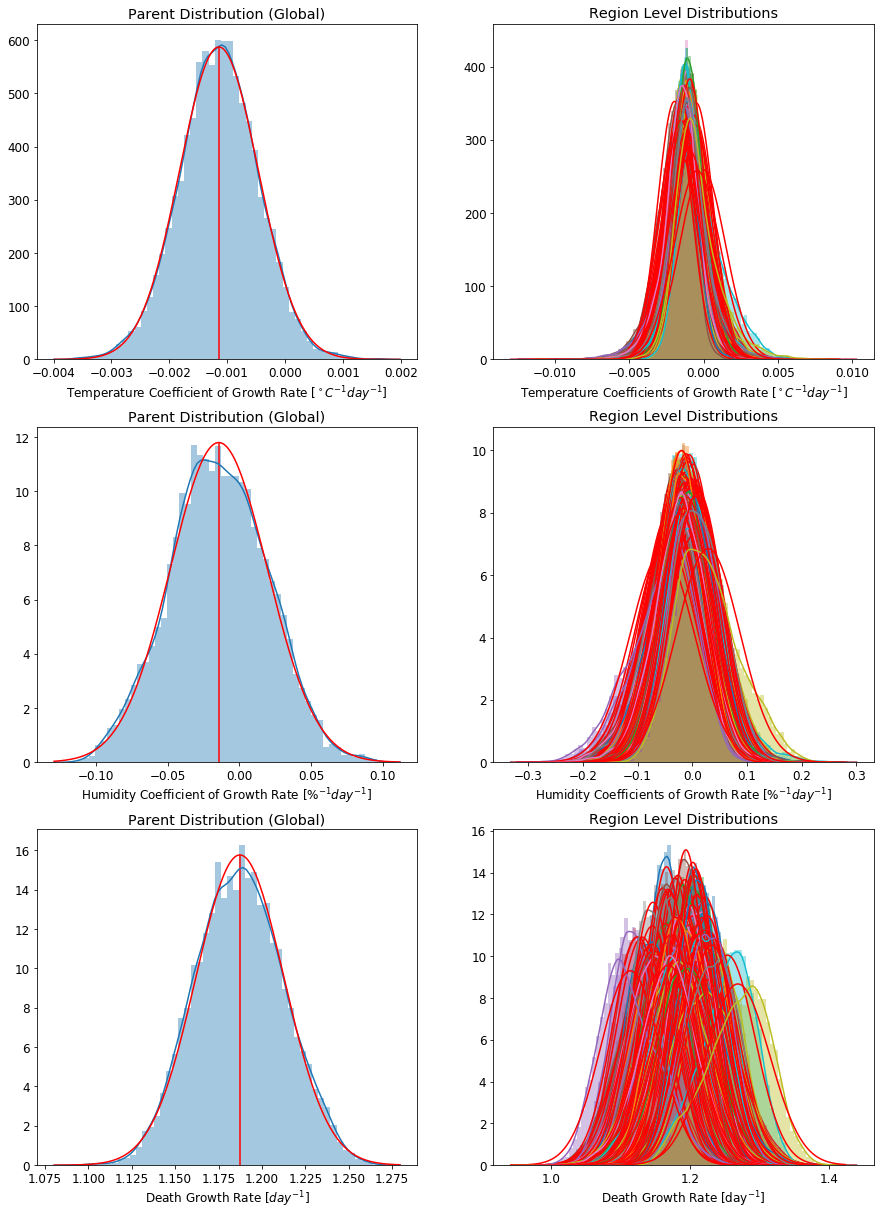

In [19]:
fig, ax = plt.subplots(3, 2, figsize=(15, 21))

plt.locator_params(axis='x', nbins=5)

sns.distplot(samples['t_grp'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, ax=ax[0,0])
ax[0,0].vlines(np.mean(samples['t_grp']), 0, norm.pdf(np.mean(samples['t_grp']), *norm.fit(samples['t_grp'])), 'r')
ax[0,0].set_title('Parent Distribution (Global)')
ax[0,0].set_xlabel(r'Temperature Coefficient of Growth Rate [$^\circ C^{-1} day^{-1}$]')


for i in range(len(samples['t_ind'][0])):
    sns.distplot(samples['t_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'red'}, ax=ax[0,1])
ax[0,1].set_title('Region Level Distributions')
ax[0,1].set_xlabel(r'Temperature Coefficients of Growth Rate [$^\circ C^{-1} day^{-1}$]')
        
sns.distplot(samples['h_grp'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, ax=ax[1,0])
ax[1,0].vlines(np.mean(samples['h_grp']), 0, norm.pdf(np.mean(samples['h_grp']), *norm.fit(samples['h_grp'])), 'r')
ax[1,0].set_title('Parent Distribution (Global)')
ax[1,0].set_xlabel(r'Humidity Coefficient of Growth Rate [$\%^{-1} day^{-1}$]')

for i in range(len(samples['h_ind'][0])):
    sns.distplot(samples['h_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'red'}, ax=ax[1,1])
ax[1,1].set_title('Region Level Distributions')
ax[1,1].set_xlabel(r'Humidity Coefficients of Growth Rate [$\%^{-1} day^{-1}$]')


sns.distplot(samples['r_grp'], bins=50, fit=norm, 
             fit_kws={'color':'red'}, ax=ax[2,0])
ax[2,0].vlines(np.mean(samples['r_grp']), 0, norm.pdf(np.mean(samples['r_grp']), *norm.fit(samples['r_grp'])), 'r')
ax[2,0].set_title('Parent Distribution (Global)')
ax[2,0].set_xlabel(r'Death Growth Rate [$day^{-1}$]')


for i in range(len(samples['r_ind'][0])):
    sns.distplot(samples['r_ind'][:,i], bins=50, fit=norm, 
                 fit_kws={'color':'red'}, ax=ax[2,1])
ax[2,1].set_title('Region Level Distributions')
ax[2,1].set_xlabel(r'Death Growth Rate [day$^{-1}$]')

plt.savefig('../plots/TempHumidDeathsSummary.png', dpi=300)

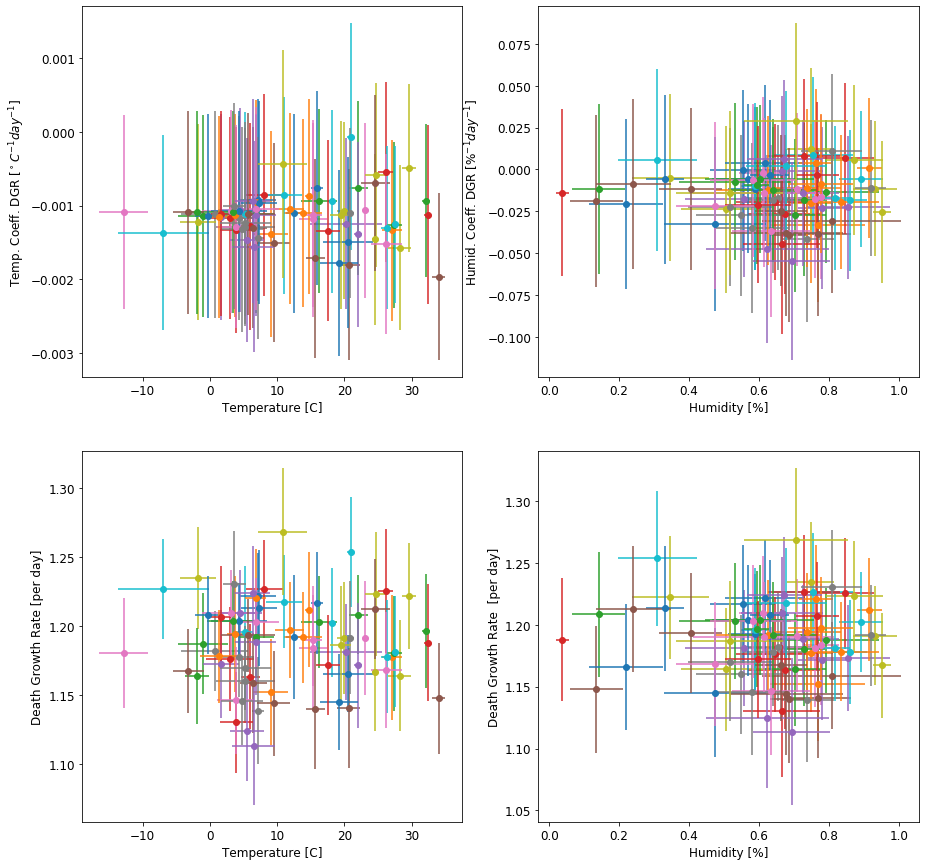

In [20]:
fig, ax = plt.subplots(2, 2,figsize=(15,15))

for i, c in enumerate(deaths.keys()):
    ax[0,0].errorbar(np.mean(temps[c]), np.mean(samples['t_ind'][:,i]),
                 xerr=np.std(temps[c]),
                 yerr=np.std(samples['t_ind'][:,i]), marker='o')
    
ax[0,0].set_xlabel('Temperature [C]')
ax[0,0].set_ylabel(r'Temp. Coeff. DGR [$^\circ C^{-1} day^{-1}$]')

for i, c in enumerate(deaths.keys()):
    ax[0,1].errorbar(np.mean(hums[c]), np.mean(samples['h_ind'][:,i]),
                 xerr=np.std(hums[c]),
                 yerr=np.std(samples['h_ind'][:,i]), marker='o')
    
ax[0,1].set_xlabel('Humidity [%]')
ax[0,1].set_ylabel(r'Humid. Coeff. DGR [$\%^{-1} day^{-1}$]')

for i, c in enumerate(deaths.keys()):
    ax[1,0].errorbar(np.mean(temps[c]), np.mean(samples['r_ind'][:,i]),
                 xerr=np.std(temps[c]),
                 yerr=np.std(samples['r_ind'][:,i]), marker='o')
    
ax[1,0].set_xlabel('Temperature [C]')
ax[1,0].set_ylabel('Death Growth Rate [per day]')

for i, c in enumerate(deaths.keys()):
    ax[1,1].errorbar(np.mean(hums[c]), np.mean(samples['r_ind'][:,i]),
                 xerr=np.std(hums[c]),
                 yerr=np.std(samples['h_ind'][:,i]), marker='o')
    
ax[1,1].set_xlabel('Humidity [%]')
ax[1,1].set_ylabel('Death Growth Rate  [per day]')

plt.savefig('../plots/TempHumidDeathVariablesBW.png', dpi=300)

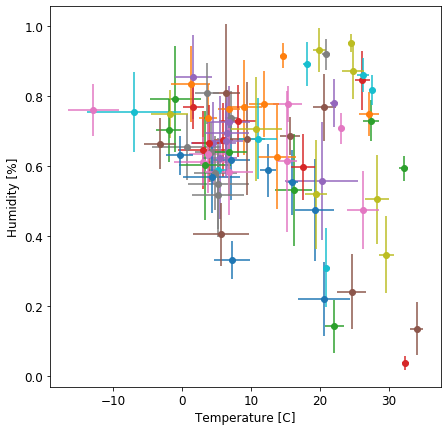

In [21]:
plt.figure(figsize=(7,7))
for i, c in enumerate(deaths.keys()):
    plt.errorbar(np.mean(temps[c]), np.mean(hums[c]),
                 xerr=np.std(temps[c]),
                 yerr=np.std(hums[c]), marker='o')
plt.xlabel('Temperature [C]')
plt.ylabel('Humidity [%]')
plt.savefig('../plots/TempVsHumid.png', dpi=300)